2025-08-08 16:15:39.446303: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-08 16:15:39.471322: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-08-08 16:15:39.471348: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-08-08 16:15:39.472091: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-08-08 16:15:39.476659: I tensorflow/core/platform/cpu_feature_guar

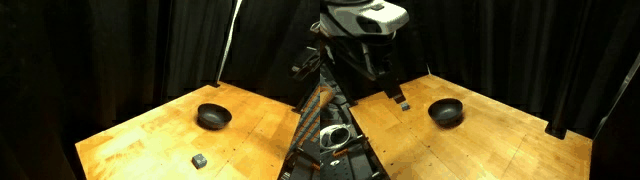

  7%|▋         | 7/100 [02:16<44:56, 28.99s/it]  

In [ ]:
import os
from tqdm import tqdm
import h5py
import torch
import collections
import tensorflow_datasets as tfds
import numpy as np
from PIL import Image
from IPython.display import display, Image as IPyImage
import argparse
import logging
import sys

logging.basicConfig(
    level=logging.INFO,
    format="[%(asctime)s] [%(levelname)s] %(message)s",
    datefmt="%H:%M:%S",
)
logger = logging.getLogger(__name__)

def recursive_dict_list_tuple_apply(x, type_func_dict):
    if isinstance(x, (dict, collections.OrderedDict)):
        new_x = collections.OrderedDict() if isinstance(x, collections.OrderedDict) else dict()
        for k, v in x.items():
            new_x[k] = recursive_dict_list_tuple_apply(v, type_func_dict)
        return new_x
    elif isinstance(x, (list, tuple)):
        ret = [recursive_dict_list_tuple_apply(v, type_func_dict) for v in x]
        return tuple(ret) if isinstance(x, tuple) else ret
    else:
        for t, f in type_func_dict.items():
            if isinstance(x, t):
                return f(x)
        return x

def to_numpy(x):
    def f(tensor):
        return tensor.detach().cpu().numpy() if tensor.is_cuda else tensor.detach().numpy()
    return recursive_dict_list_tuple_apply(
        x,
        {torch.Tensor: f, np.ndarray: lambda x: x, type(None): lambda x: x}
    )

def _axis_angle_rotation(axis, angle):
    cos = torch.cos(angle)
    sin = torch.sin(angle)
    one = torch.ones_like(angle)
    zero = torch.zeros_like(angle)
    if axis == "X":
        R = (one, zero, zero, 0*angle, cos, -sin, 0*angle, sin, cos)
    elif axis == "Y":
        R = (cos, 0*angle, sin, 0*angle, one, 0*angle, -sin, 0*angle, cos)
    elif axis == "Z":
        R = (cos, -sin, 0*angle, sin, cos, 0*angle, 0*angle, 0*angle, one)
    else:
        raise ValueError("Axis must be X, Y, or Z")
    return torch.stack(R, -1).reshape(angle.shape + (3, 3))

def euler_angles_to_matrix(euler_angles, convention):
    matrices = [_axis_angle_rotation(c, e) for c, e in zip(convention, torch.unbind(euler_angles, -1))]
    return matrices[0] @ matrices[1] @ matrices[2]

def matrix_to_rotation_6d(matrix):
    batch_dim = matrix.size()[:-2]
    return matrix[..., :2, :].clone().reshape(batch_dim + (6,))

def euler_angles_to_rot_6d(euler_angles, convention="XYZ"):
    return matrix_to_rotation_6d(euler_angles_to_matrix(euler_angles, convention))

def show_gif(images_pil_list, save_dir):
    os.makedirs(save_dir, exist_ok=True)
    path = os.path.join(save_dir, 'result.gif')
    images_pil_list[0].save(
        path, save_all=True, append_images=images_pil_list[1:],
        duration=int(1000/15), loop=0
    )
    try:
        display(IPyImage(filename=path))
    except Exception as e:
        logger.info(f"GIF saved at {path} (display skipped): {e}")

def generate_h5(obs_replay, action_replay, cfg, total_traj_cnt, act_root_dir_path, edit_flag):
    data_dict = {
        '/observations/qpos': obs_replay['qpos'],   # (T,7)
        '/observations/qvel': obs_replay['qvel'],   # (T,7)
        '/action': action_replay,                   # (T,10)
        'is_edited': np.array(edit_flag, dtype=np.int32),
    }
    for cam_name in cfg['camera_names']:
        data_dict[f'/observations/images/{cam_name}'] = obs_replay['images'][cam_name]

    max_timesteps = len(data_dict['/observations/qpos'])
    dataset_path = os.path.join(act_root_dir_path, f'episode_{total_traj_cnt}')
    with h5py.File(dataset_path + '.hdf5', 'w', rdcc_nbytes=1024**2*2) as root:
        root.attrs['sim'] = True
        obs = root.create_group('observations')
        image = obs.create_group('images')

        for cam_name in cfg['camera_names']:
            image.create_dataset(
                cam_name,
                (max_timesteps, cfg['cam_height'], cfg['cam_width'], 3),
                dtype='uint8',
                chunks=(1, cfg['cam_height'], cfg['cam_width'], 3)
            )

        obs.create_dataset('qpos', (max_timesteps, cfg['qpos_dim']), dtype='float32')
        obs.create_dataset('qvel', (max_timesteps, cfg['qpos_dim']), dtype='float32')
        root.create_dataset('action', (max_timesteps, cfg['action_dim']), dtype='float32')
        root.create_dataset('is_edited', (1,), dtype='int32')
        root.create_dataset("language_raw", data=[np.string_(cfg['lang_intrs'])])

        for name, array in data_dict.items():
            root[name][...] = array

def main():
    parser = argparse.ArgumentParser(description="DROID TFDS → HDF5 변환기")
    parser.add_argument("--dataset_name", type=str, default="droid_100", help="TFDS dataset name")
    parser.add_argument("--dataset_dir", type=str, required=True, help="TFDS data_dir")
    parser.add_argument("--output_dir", type=str, required=True, help="HDF5 output root")
    parser.add_argument("--task_name", type=str, default="droid_1dot7t_lang", help="task folder name")
    parser.add_argument("--camera_names", type=str, nargs="+", default=["left", "right", "wrist"], help="camera names")
    parser.add_argument("--cam_height", type=int, default=180, help="image height (auto-updated if mismatch)")
    parser.add_argument("--cam_width", type=int, default=320, help="image width (auto-updated if mismatch)")
    parser.add_argument("--qpos_dim", type=int, default=7, help="qpos/qvel dim (fixed to 7)")
    parser.add_argument("--action_dim", type=int, default=10, help="action dim (fixed to 10)")
    parser.add_argument("--default_lang", type=str, default="close the lid of the box", help="fallback language")
    parser.add_argument("--interactive", type=lambda s: s.lower() in ["1","true","t","yes","y"], default=False,
                        help="ask user to type language if empty (Jupyter/terminal)")
    parser.add_argument("--rot_in_degrees", type=lambda s: s.lower() in ["1","true","t","yes","y"], default=False,
                        help="set True if Euler angles are in degrees")
    parser.add_argument("--resize_to_cfg", type=lambda s: s.lower() in ["1","true","t","yes","y"], default=False,
                        help="resize frames to (cam_width, cam_height) on mismatch")
    parser.add_argument("--gif_when_edit", type=lambda s: s.lower() in ["1","true","t","yes","y"], default=False,
                        help="show GIF preview if editing language")
    parser.add_argument("--skip_if_no_lang", type=lambda s: s.lower() in ["1","true","t","yes","y"], default=False,
                        help="스텝 전체에 언어 지시문이 전혀 없으면 episode를 건너뜀")
    args = parser.parse_args()

    DATASET_DIR = args.dataset_dir
    OUTPUT_H5_DIR = args.output_dir
    os.makedirs(OUTPUT_H5_DIR, exist_ok=True)

    cfg = {
        "task_name": args.task_name,
        "camera_names": args.camera_names,
        "cam_height": args.cam_height,
        "cam_width": args.cam_width,
        "qpos_dim": args.qpos_dim,      # 7
        "action_dim": args.action_dim,  # 10
        "lang_intrs": args.default_lang
    }

    act_root_dir_name = f'{cfg["task_name"]}_succ_t0001_s-0-0'
    act_root_dir_path = os.path.join(OUTPUT_H5_DIR, act_root_dir_name)
    os.makedirs(act_root_dir_path, exist_ok=True)
    logger.info(f"Output dir: {act_root_dir_path}")

    logger.info(f"Loading TFDS: {args.dataset_name} (data_dir={DATASET_DIR})")
    ds = tfds.load(args.dataset_name, data_dir=DATASET_DIR, split="train")
    total_traj_cnt = 0

    for episode in tqdm(ds, desc="Converting episodes"):
        save_path = os.path.join(act_root_dir_path, f'episode_{total_traj_cnt}.hdf5')
        if os.path.exists(save_path):
            logger.info(f"Skip existing: {save_path}")
            total_traj_cnt += 1
            continue

        cur_actions_dict = {}
        cur_obs_image = {'1': [], '2': []}
        cur_obs_wrist_image = []
        cur_obs_gripper_pos = []
        cur_obs_joint_state = []
        cur_obs_ee_pos = []

        # 언어 지시문 추출 상태
        found_lang = False
        raw_lang = None

        for idx, step in enumerate(episode['steps']):
            if idx == 0:
                cur_actions_dict = {k: [] for k in step['action_dict'].keys()}

            # 언어 지시문 3개 후보 중 유효한 것(>=4자) 발견 시 최초 1개만 채택
            l1 = step['language_instruction'].numpy().decode('utf-8').strip()
            l2 = step['language_instruction_2'].numpy().decode('utf-8').strip()
            l3 = step['language_instruction_3'].numpy().decode('utf-8').strip()
            cand = l1 if len(l1) >= 4 else (l2 if len(l2) >= 4 else l3)
            if (not found_lang) and len(cand) >= 4:
                raw_lang = cand
                found_lang = True

            cur_obs_image['1'].append(step['observation']['exterior_image_1_left'].numpy())
            cur_obs_image['2'].append(step['observation']['exterior_image_2_left'].numpy())
            cur_obs_wrist_image.append(step['observation']['wrist_image_left'].numpy())
            cur_obs_gripper_pos.append(step['observation']['gripper_position'].numpy())
            cur_obs_joint_state.append(step['observation']['joint_position'].numpy())
            cur_obs_ee_pos.append(step['observation']['cartesian_position'].numpy()[:2])

            for k in cur_actions_dict:
                cur_actions_dict[k].append(step['action_dict'][k].numpy())

        lengths = [
            len(cur_obs_image['1']), len(cur_obs_image['2']), len(cur_obs_wrist_image),
            len(cur_obs_joint_state), len(cur_obs_gripper_pos), len(cur_obs_ee_pos),
            len(cur_actions_dict.get('cartesian_position', [])),
            len(cur_actions_dict.get('gripper_position', [])),
        ]
        traj_len = min(lengths)
        if traj_len <= 0:
            logger.info(f"Skip episode_{total_traj_cnt}: empty or invalid lengths={lengths}")
            total_traj_cnt += 1
            continue

        # 언어 지시문이 한 스텝도 없으면 스킵/보충
        if not found_lang:
            if args.skip_if_no_lang:
                logger.info(f"Skip episode_{total_traj_cnt}: no language instruction found.")
                total_traj_cnt += 1
                continue
            else:
                if args.interactive:
                    try:
                        raw_lang = input("please write a language instruction: ").strip()
                    except Exception:
                        raw_lang = ""
                if not raw_lang or len(raw_lang) < 4:
                    raw_lang = args.default_lang

        cur_obs_image['1']        = cur_obs_image['1'][:traj_len]
        cur_obs_image['2']        = cur_obs_image['2'][:traj_len]
        cur_obs_wrist_image       = cur_obs_wrist_image[:traj_len]
        cur_obs_joint_state       = cur_obs_joint_state[:traj_len]
        cur_obs_gripper_pos       = cur_obs_gripper_pos[:traj_len]
        cur_obs_ee_pos            = cur_obs_ee_pos[:traj_len]
        cur_actions_dict['cartesian_position'] = cur_actions_dict['cartesian_position'][:traj_len]
        cur_actions_dict['gripper_position']   = cur_actions_dict['gripper_position'][:traj_len]

        h_left,  w_left  = cur_obs_image['1'][0].shape[:2]
        h_right, w_right = cur_obs_image['2'][0].shape[:2]
        h_wrist, w_wrist = cur_obs_wrist_image[0].shape[:2]
        if not ((h_left, w_left) == (h_right, w_right) == (h_wrist, w_wrist)):
            raise ValueError(f"Camera resolutions differ: left={h_left,w_left}, right={h_right,w_right}, wrist={h_wrist,w_wrist}")

        if (cfg['cam_height'], cfg['cam_width']) != (h_left, w_left):
            if args.resize_to_cfg:
                logger.warning(f"Resizing frames to cfg ({cfg['cam_height']},{cfg['cam_width']}) from ({h_left},{w_left})")
                def _resize_list(img_list):
                    return [np.array(Image.fromarray(x).resize((cfg['cam_width'], cfg['cam_height']))) for x in img_list]
                cur_obs_image['1']  = _resize_list(cur_obs_image['1'])
                cur_obs_image['2']  = _resize_list(cur_obs_image['2'])
                cur_obs_wrist_image = _resize_list(cur_obs_wrist_image)
                h_left, w_left = cfg['cam_height'], cfg['cam_width']
            else:
                logger.info(f"Auto-updating cfg cam size to ({h_left},{w_left})")
                cfg['cam_height'], cfg['cam_width'] = h_left, w_left

        in_action = np.array(cur_actions_dict['cartesian_position'], dtype=np.float32)  # (T,6)
        in_pos = in_action[:, :3]
        in_rot = in_action[:, 3:6]
        if args.rot_in_degrees:
            in_rot = np.deg2rad(in_rot)
        rot_6d = euler_angles_to_rot_6d(torch.from_numpy(in_rot.astype(np.float32))).numpy()

        gripper = np.array(cur_actions_dict['gripper_position'], dtype=np.float32)
        if gripper.ndim == 1:
            gripper = gripper.reshape(-1, 1)

        assert in_pos.shape[0] == rot_6d.shape[0] == gripper.shape[0] == traj_len, \
            f"Length mismatch: pos={in_pos.shape}, rot6d={rot_6d.shape}, grip={gripper.shape}, len={traj_len}"
        traj_actions = np.concatenate((in_pos, rot_6d, gripper), axis=-1)
        assert traj_actions.shape[1] == cfg['action_dim'] == 10, f"action dim != 10: {traj_actions.shape}"

        traj_qpos = np.array(cur_obs_joint_state, dtype=np.float32)
        traj_qvel = np.zeros_like(traj_qpos)
        assert traj_qpos.shape == traj_qvel.shape == (traj_len, cfg['qpos_dim']) == (traj_len, 7), \
            f"qpos/qvel shape mismatch: qpos={traj_qpos.shape}, qvel={traj_qvel.shape}"

        left_imgs  = np.array(cur_obs_image['1'],  dtype=np.uint8)
        right_imgs = np.array(cur_obs_image['2'],  dtype=np.uint8)
        wrist_imgs = np.array(cur_obs_wrist_image, dtype=np.uint8)

        cfg['lang_intrs'] = raw_lang

        obs_replay = {
            'qpos': traj_qpos,
            'qvel': traj_qvel,
            'images': {
                'left':  left_imgs,
                'right': right_imgs,
                'wrist': wrist_imgs,
            }
        }

        assert obs_replay['images']['left'].shape[1:3] == (cfg['cam_height'], cfg['cam_width']), \
            f"Left image shape mismatch: {obs_replay['images']['left'].shape} vs cfg {(cfg['cam_height'], cfg['cam_width'])}"
        assert obs_replay['qpos'].shape == (traj_len, cfg['qpos_dim'])
        assert obs_replay['qvel'].shape == (traj_len, cfg['qpos_dim'])
        assert traj_actions.shape == (traj_len, cfg['action_dim'])

        generate_h5(obs_replay, traj_actions, cfg, total_traj_cnt, act_root_dir_path, edit_flag=0)

        logger.info(f"Saved episode_{total_traj_cnt}.hdf5  | "
                    f"T={traj_len}, action_dim={traj_actions.shape[1]}, qpos/qvel_dim={cfg['qpos_dim']} | "
                    f"cam=({cfg['cam_height']},{cfg['cam_width']}) | lang='{cfg['lang_intrs']}'")

        total_traj_cnt += 1

    logger.info("All done!")

if __name__ == "__main__":
    try:
        main()
    except AssertionError as e:
        logger.error(f"Assertion failed: {e}")
        sys.exit(1)
    except Exception as e:
        logger.exception(e)
        sys.exit(1)
